In [1]:
%matplotlib inline

import pandas
import statistics
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn import preprocessing

In [2]:
# bug fix for display formats to avoid run time errors
pandas.set_option('display.float_format', lambda x:'%.2f'%x)

#load the data
data = pandas.read_csv('..\separatedData.csv')

# convert to numeric format
data["breastCancer100th"] = pandas.to_numeric(data["breastCancer100th"], errors='coerce')
data["meanSugarPerson"]   = pandas.to_numeric(data["meanSugarPerson"], errors='coerce')
data["meanFoodPerson"]   = pandas.to_numeric(data["meanFoodPerson"], errors='coerce')
data["meanCholesterol"]   = pandas.to_numeric(data["meanCholesterol"], errors='coerce')

# listwise deletion of missing values
sub1 = data[['breastCancer100th', 'meanFoodPerson', 'meanCholesterol', 'meanSugarPerson']].dropna()

# Create the conditions to a new variable named incidence_cancer that will categorize the meanSugarPerson answers
meanIncidence = statistics.mean(sub1['breastCancer100th'])

def incidence_cancer (row):
    if row['breastCancer100th'] <= meanIncidence : return 0   # Incidence of breast cancer is below the
                                                              # average of the incidence of all countries.
    if row['breastCancer100th'] > meanIncidence  : return 1   # Incidence of breast cancer is above the average
                                                              # of the incidence of all countries.

# Add the new variable sugar_consumption to subData
sub1['incidence_cancer'] = sub1.apply (lambda row: incidence_cancer (row),axis=1)

#Split into training and testing sets
predvar = sub1[[ 'meanSugarPerson', 'meanFoodPerson', 'meanCholesterol']]
targets = sub1['incidence_cancer']

In [3]:
# standardize predictors to have mean=0 and sd=1
predictors = predvar.copy()
predictors['meanSugarPerson']=preprocessing.scale(predictors['meanSugarPerson'].astype('float64'))
predictors['meanFoodPerson']=preprocessing.scale(predictors['meanFoodPerson'].astype('float64'))
predictors['meanCholesterol']=preprocessing.scale(predictors['meanCholesterol'].astype('float64'))

# split data into train and test sets - Train = 70%, Test = 30%
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets,
                                                              test_size=.3, random_state=123)

In [4]:
# specify the lasso regression model
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

# print variable names and regression coefficients
dict(zip(predictors.columns, model.coef_))

{'meanCholesterol': 0.22564201762237368,
 'meanFoodPerson': 0.15430005397580904,
 'meanSugarPerson': 0.0002943836394151331}

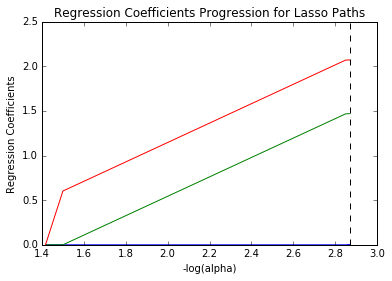

In [5]:
# plot coefficient progression
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')

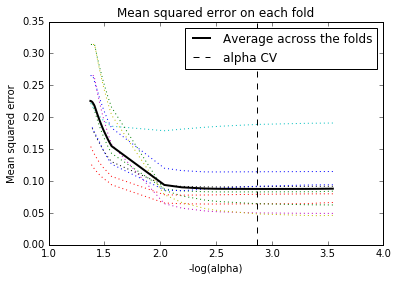

In [6]:
# plot mean square error for each fold
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

In [7]:
# MSE from training and test data
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)

training data MSE
0.0790314442922
test data MSE
0.12526564828


In [8]:
# R-square from training and test data
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

training data R-square
0.638126230205
test data R-square
0.411947373351
